# DeepFool ATTACK

In [1]:
# !pip install facenet-pytorch
# !pip install Pillow
# !pip install -q tensorflow==2.0.0
# !pip install adversarial-robustness-toolbox[all]
# !pip install matplotlib

### *Import*



### initialization

In [2]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod
from utils import load_test_image_NN2_preprocessed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)
print(device)

cuda


In [3]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    nn1 = inception.InceptionResnetV1(pretrained='vggface2').eval()
    nn1 .classify = True
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    nn1  = InceptionResnetV1(pretrained='vggface2').eval()
    nn1.classify = True

Import Inception.Inception


In [4]:
nn1.classify = True
nn1.to(device)
fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

In [5]:
def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    tns.to(device)
    return tns
model_nn1 = PyTorchClassifier(nn1,input_shape=[160,160], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


In [6]:
from RESNET import ResNet
from utils import get_labels
from utils import load_state_dict

nn2 = ResNet.resnet50(num_classes=8631, include_top=True)


load_state_dict(nn2,'resnet50_scratch_weight.pkl')
nn2.eval()

model_nn2 = PyTorchClassifier(nn2,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device)

LABELS = get_labels()

### Untargeted Attack on all test set

In [14]:
from art.attacks.evasion import DeepFool
import os
import re
import numpy as np
from utils import load_image_NN1, load_test_image_NN2

dataset_dir = "test_set_cropped_piccolo/"
#eps_step = [0.001, 0.02 ,0.05, 0.07, 0.3, 0.5, 0.7, 1]
#eps_step = [0.00001, 0.0001, 0.001, 0.003, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.7, 1, 2]
#eps_step = [1e-20, 1e-15, 1e-10, 1]
eps_step =[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
max_iter = [1,5]
accuracy_for_eps_nn2_preprocessed=np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2_preprocessed=0

accuracy_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn1 = 0

accuracy_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2 = 0



total_images = 0
print("Inizio Attacco DeepFool NON-TARGETED")

# Ensure models and labels are defined and loaded
# model_nn1, model_nn2, LABELS should be defined here
for i in range(len(max_iter)):
    for j in range(len(eps_step)):
        correct_predictions_nn1 = 0
        correct_predictions_nn2 = 0
        correct_predictions_nn2_preprocessed=0
        total_images = 0

        perturbations = []
        attack = DeepFool(classifier=model_nn1, epsilon=eps_step[j], max_iter=max_iter[i])

        print(f"**** Attacco con eps: {eps_step[j]} ****")
        for filename in os.listdir(dataset_dir):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                person_path = os.path.join(dataset_dir, filename)
                test_img = load_image_NN1(person_path, device).numpy()
                test_images_adv = attack.generate(test_img)
                nn1_predictions = model_nn1.predict(test_images_adv)
                test_images_NN2 = load_test_image_NN2(test_images_adv)
                nn2_predictions = model_nn2.predict(test_images_NN2)

                test_images_NN2_preprocessed= load_test_image_NN2_preprocessed(test_images_adv)
                nn2_prediction_preprocessed=model_nn2.predict(test_images_NN2_preprocessed)

                correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                perturbations.append(np.mean(np.abs(test_images_adv - test_img)))

                predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                predicted_label_nn2_preprocessed= LABELS[np.array(nn2_prediction_preprocessed.argmax())]

                total_images += 1

                if correct_label in predicted_label_nn1:
                    correct_predictions_nn1 += 1

                if correct_label in predicted_label_nn2:
                    correct_predictions_nn2 += 1

                if correct_label in predicted_label_nn2_preprocessed:
                    correct_predictions_nn2_preprocessed +=1

        if total_images != 0:
            perturbation_mean = np.mean(perturbations)
            perturbation_for_eps_nn1[i][j]=perturbation_mean
        
            accuracy_nn1 = correct_predictions_nn1 / total_images
            accuracy_for_eps_nn1[i][j]=accuracy_nn1

            accuracy_nn2 = correct_predictions_nn2/ total_images
            accuracy_for_eps_nn2[i][j]=accuracy_nn2

            accuracy_nn2_preprocessed= correct_predictions_nn2_preprocessed/total_images
            accuracy_for_eps_nn2_preprocessed[i][j]=accuracy_nn2_preprocessed

            print(f"Accuracy Inception ResNet for eps {eps_step[j]}: {accuracy_nn1}")
            print(f"Accuracy Resnet50 for eps {eps_step[j]}: {accuracy_nn2}")
            print(f"Average perturbation for eps {eps_step[j]}: {perturbation_mean}")


Inizio Attacco DeepFool NON-TARGETED
**** Attacco con eps: 0.05 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.05: 0.3
Accuracy Resnet50 for eps 0.05: 1.0
Average perturbation for eps 0.05: 0.0013108050916343927
**** Attacco con eps: 0.1 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.1: 0.3
Accuracy Resnet50 for eps 0.1: 1.0
Average perturbation for eps 0.1: 0.001373225124552846
**** Attacco con eps: 0.15 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.15: 0.3
Accuracy Resnet50 for eps 0.15: 1.0
Average perturbation for eps 0.15: 0.0014356446918100119
**** Attacco con eps: 0.2 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.2: 0.3
Accuracy Resnet50 for eps 0.2: 1.0
Average perturbation for eps 0.2: 0.0014980633277446032
**** Attacco con eps: 0.25 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.25: 0.2
Accuracy Resnet50 for eps 0.25: 0.9
Average perturbation for eps 0.25: 0.0015604819636791945
**** Attacco con eps: 0.3 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.3: 0.2
Accuracy Resnet50 for eps 0.3: 0.9
Average perturbation for eps 0.3: 0.0016229035099968314
**** Attacco con eps: 0.35 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.35: 0.2
Accuracy Resnet50 for eps 0.35: 0.9
Average perturbation for eps 0.35: 0.00168532133102417
**** Attacco con eps: 0.4 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.4: 0.2
Accuracy Resnet50 for eps 0.4: 0.9
Average perturbation for eps 0.4: 0.001747740781866014
**** Attacco con eps: 0.45 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.45: 0.2
Accuracy Resnet50 for eps 0.45: 0.9
Average perturbation for eps 0.45: 0.0018101586028933525
**** Attacco con eps: 0.5 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.5: 0.2
Accuracy Resnet50 for eps 0.5: 0.9
Average perturbation for eps 0.5: 0.0018725802656263113
**** Attacco con eps: 0.6 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.6: 0.2
Accuracy Resnet50 for eps 0.6: 0.9
Average perturbation for eps 0.6: 0.001997418003156781
**** Attacco con eps: 0.7 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.7: 0.2
Accuracy Resnet50 for eps 0.7: 0.9
Average perturbation for eps 0.7: 0.0021222576033324003
**** Attacco con eps: 0.8 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.8: 0.2
Accuracy Resnet50 for eps 0.8: 0.9
Average perturbation for eps 0.8: 0.0022470930125564337
**** Attacco con eps: 0.9 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.9: 0.2
Accuracy Resnet50 for eps 0.9: 0.9
Average perturbation for eps 0.9: 0.002371932612732053
**** Attacco con eps: 0.05 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.05: 0.1
Accuracy Resnet50 for eps 0.05: 1.0
Average perturbation for eps 0.05: 0.001597649767063558
**** Attacco con eps: 0.1 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.1: 0.1
Accuracy Resnet50 for eps 0.1: 1.0
Average perturbation for eps 0.1: 0.0016690269112586975
**** Attacco con eps: 0.15 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.15: 0.1
Accuracy Resnet50 for eps 0.15: 1.0
Average perturbation for eps 0.15: 0.0017475064378231764
**** Attacco con eps: 0.2 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.2: 0.1
Accuracy Resnet50 for eps 0.2: 1.0
Average perturbation for eps 0.2: 0.0018198678735643625
**** Attacco con eps: 0.25 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.25: 0.1
Accuracy Resnet50 for eps 0.25: 0.9
Average perturbation for eps 0.25: 0.0018965776544064283
**** Attacco con eps: 0.3 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.3: 0.1
Accuracy Resnet50 for eps 0.3: 0.9
Average perturbation for eps 0.3: 0.0019715980160981417
**** Attacco con eps: 0.35 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.35: 0.1
Accuracy Resnet50 for eps 0.35: 0.9
Average perturbation for eps 0.35: 0.0020537073723971844
**** Attacco con eps: 0.4 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.4: 0.1
Accuracy Resnet50 for eps 0.4: 0.9
Average perturbation for eps 0.4: 0.0021266653202474117
**** Attacco con eps: 0.45 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.45: 0.1
Accuracy Resnet50 for eps 0.45: 0.9
Average perturbation for eps 0.45: 0.002198657253757119
**** Attacco con eps: 0.5 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.5: 0.1
Accuracy Resnet50 for eps 0.5: 0.9
Average perturbation for eps 0.5: 0.0022765505127608776
**** Attacco con eps: 0.6 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.6: 0.1
Accuracy Resnet50 for eps 0.6: 0.9
Average perturbation for eps 0.6: 0.0024333451874554157
**** Attacco con eps: 0.7 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.7: 0.1
Accuracy Resnet50 for eps 0.7: 0.9
Average perturbation for eps 0.7: 0.00258503295481205
**** Attacco con eps: 0.8 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.8: 0.1
Accuracy Resnet50 for eps 0.8: 0.9
Average perturbation for eps 0.8: 0.002731457818299532
**** Attacco con eps: 0.9 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.9: 0.1
Accuracy Resnet50 for eps 0.9: 0.9
Average perturbation for eps 0.9: 0.0028899211902171373


In [15]:
print(eps_step)

print(accuracy_for_eps_nn1)
print("\n")
print(accuracy_for_eps_nn2)
print("\n")
print(accuracy_for_eps_nn2_preprocessed)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
[[0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]


[[1.  1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [1.  1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


ValueError: x and y must have same first dimension, but have shapes (14,) and (2, 14)

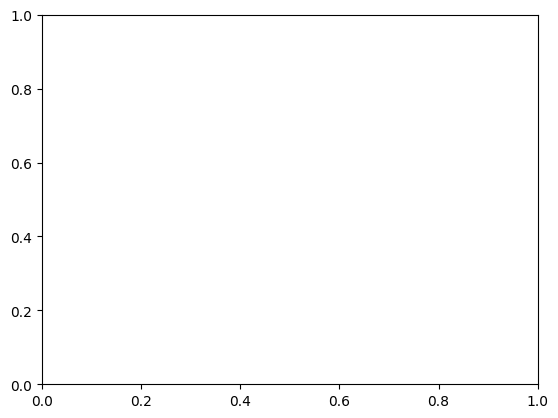

In [16]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1), 'b--', label='NN1')
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2), 'r--', label='NN2')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

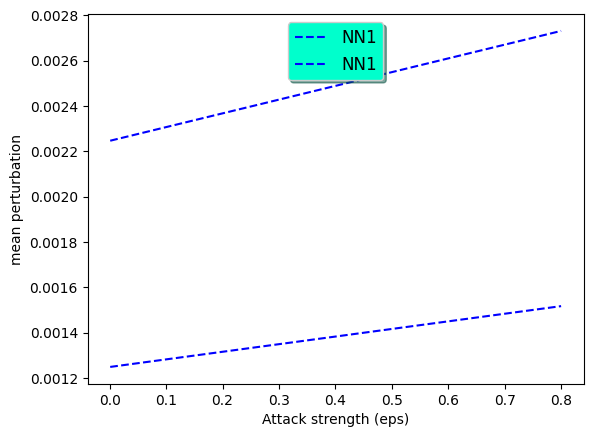

In [10]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

### Single sample Untargeted attack

In [11]:
from art.attacks.evasion import DeepFool

epsilon =2
max_iter = 5

attack = DeepFool(classifier=model_nn1, epsilon=epsilon, max_iter=max_iter)

In [12]:
from utils import load_image_NN1
dataset_dir = "test_set_cropped/"
filename = "Andrea_Pirlo_4_face_0.jpg"

person_path = os.path.join(dataset_dir, filename)
test_img = load_image_NN1(person_path,device)
test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy)

nn1_predictions = model_nn1.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))


test_images_NN2 = load_test_image_NN2(test_images_adv)
nn2_predictions = model_nn2.predict(test_images_NN2)



predicted_label_nn1= LABELS[np.array(nn1_predictions.argmax())]
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
print("NN1{} con probabilità {}".format(predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2,nn2_predictions[0][nn2_predictions.argmax()]))


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Average perturbation: 0.01
NN1 Joacim_Cans con probabilità 10.063989639282227
NN2 Andrea_Pirlo con probabilità 10.893476486206055


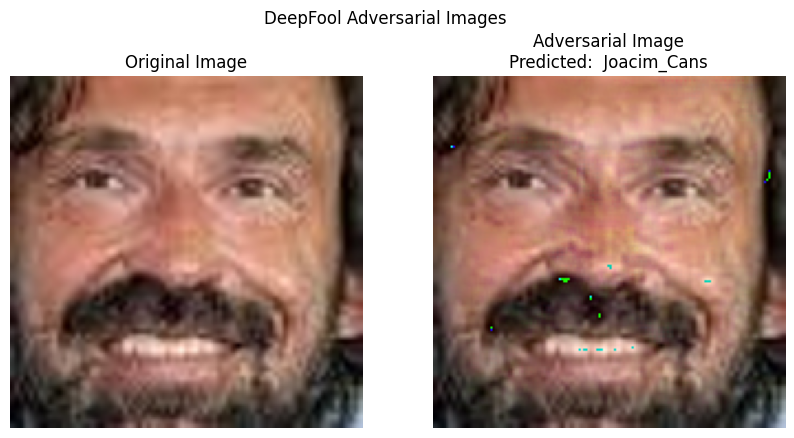

In [13]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label_nn1}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()
